<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/InitialModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import keras

print(tf.__version__)

2.12.0


## Preparing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
filenames = os.listdir("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train")

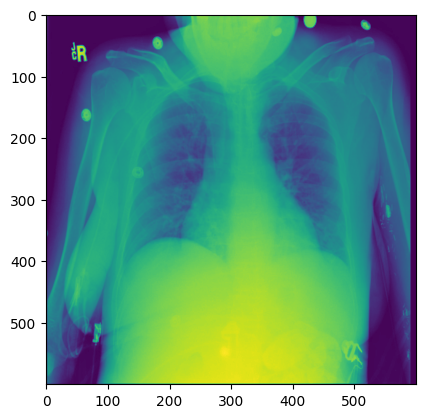

In [28]:
from PIL import Image
train_imgs = np.empty((0,600, 600))
FileIDs = []
lst = []

count = 0
for file in filenames:
  if count == 500:
    break

  #Making sure the images are the same pixel size
  img = Image.open(f"/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train/{file}")
  img = img.resize((600,600))
  img = np.array(img)

  #add extra dimension so we can concatenate
  img = np.expand_dims(img,(0))

  #Save filename for later
  FileIDs.append(file)

  #adding to train_imgs array
  train_imgs = np.concatenate((train_imgs, img), axis = 0)

  count += 1

In [29]:
#extracting just the CVC labels
train_data = pd.read_csv("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train.csv")
CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]
CVC_train.set_index('StudyInstanceUID', inplace=True)
CVC_train.head()

,CVC - Abnormal,CVC - Borderline,CVC - Normal
StudyInstanceUID,,,
1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561,0,0,0
1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729,0,0,1
1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,1,0
1.2.826.0.1.3680043.8.498.68286643202323212801283518367144358744,1,0,0
1.2.826.0.1.3680043.8.498.10050203009225938259119000528814762175,0,0,1


In [30]:
#cleaning up the labels
UID = []
for i in range(len(FileIDs)):
  UID.append(FileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.96373614405512283046314488555604647941',
 '1.2.826.0.1.3680043.8.498.96315500926641444675409331764690933307',
 '1.2.826.0.1.3680043.8.498.96450515721778915344219421534269786290',
 '1.2.826.0.1.3680043.8.498.96255059007178680952242469330314808585',
 '1.2.826.0.1.3680043.8.498.96311228469094629679821868712032248786',
 '1.2.826.0.1.3680043.8.498.96359554498564333142663951388648557789',
 '1.2.826.0.1.3680043.8.498.96447675290915183668080373345495953473',
 '1.2.826.0.1.3680043.8.498.96279880013483713441521686300695558821',
 '1.2.826.0.1.3680043.8.498.96349754766067875463134738379718157835',
 '1.2.826.0.1.3680043.8.498.96258089029863343818062710263042584654']

In [31]:
train_labels = np.empty((0,3))
data = []
for ID in UID:
    data.append(CVC_train.loc[ID])

train_labels_df = pd.DataFrame(data)

train_labels_df = train_labels_df.reindex(UID)

train_labels = train_labels_df.values

## Making and training the model

In [32]:
if np.all(train_labels[1] == [0,0,1]):
  print('hello')

In [43]:
def get_allignment(labels):
  result = ""
  if np.any(labels == [2,2,1]):
    result += "Normal"

  elif np.any(labels == [2,1,2]):
    result += "Borderline"

  elif np.any(labels == [1,2,2]):
    result += "Abnormal"

  else:
    result += "Missing"

  return result

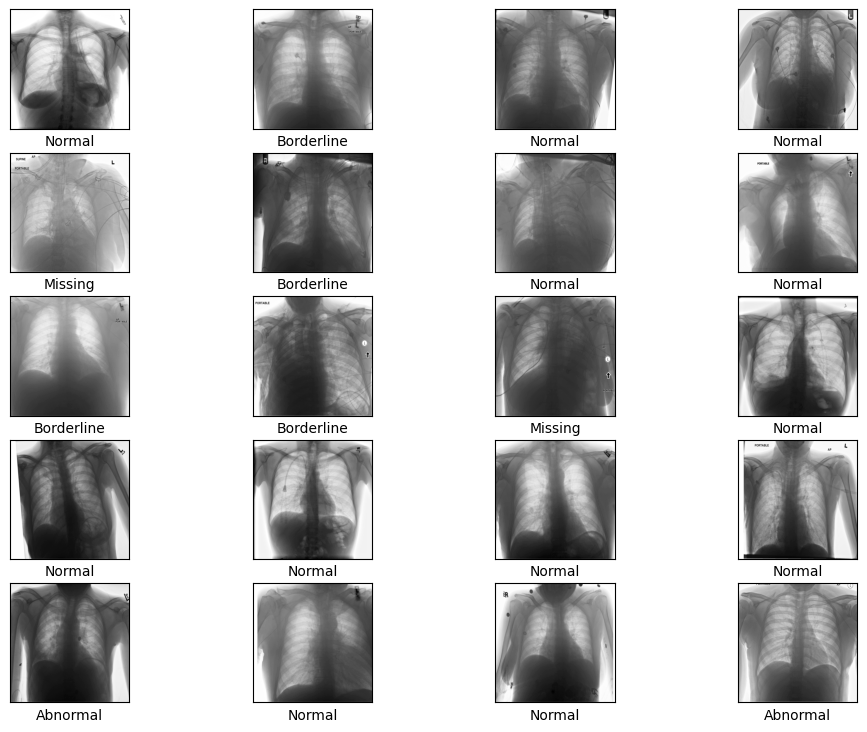

In [44]:
#displaying 6 of the images in the train_imgs array
plt.figure(figsize=(12,9))
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_imgs[i], cmap=plt.cm.binary)
  plt.xlabel(get_allignment(train_labels[i]))
plt.show()

In [45]:
lr = 0.000005
epochs=100
img_size = (600, 600)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=img_size),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3)
    ])

In [51]:
optim = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optim,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],)

In [52]:
history = model.fit(train_imgs, train_labels, epochs=epochs)

Epoch 1/100
16/16 [==============================] - 7s 384ms/step - loss: 148.6132 - accuracy: 0.4920
Epoch 2/100
16/16 [==============================] - 7s 418ms/step - loss: 96.6223 - accuracy: 0.5160
Epoch 3/100
16/16 [==============================] - 6s 343ms/step - loss: 43.1377 - accuracy: 0.4740
Epoch 4/100
16/16 [==============================] - 7s 457ms/step - loss: 29.7928 - accuracy: 0.5100
Epoch 5/100
16/16 [==============================] - 5s 339ms/step - loss: 18.7600 - accuracy: 0.5260
Epoch 6/100
16/16 [==============================] - 6s 410ms/step - loss: 16.6623 - accuracy: 0.5320
Epoch 7/100
16/16 [==============================] - 7s 421ms/step - loss: 20.2142 - accuracy: 0.5520
Epoch 8/100
16/16 [==============================] - 8s 485ms/step - loss: 15.2939 - accuracy: 0.5500
Epoch 9/100
16/16 [==============================] - 6s 376ms/step - loss: 26.0745 - accuracy: 0.5120
Epoch 10/100
16/16 [==============================] - 5s 336ms/step - loss: 27.59

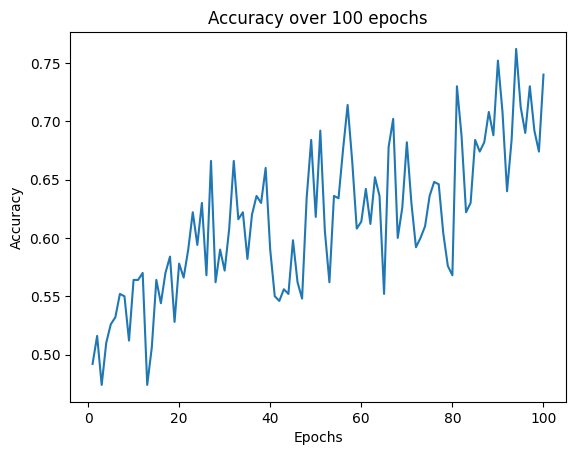

In [53]:

plt.plot(range(1,epochs+1), history.history["accuracy"])
plt.title(f"Accuracy over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

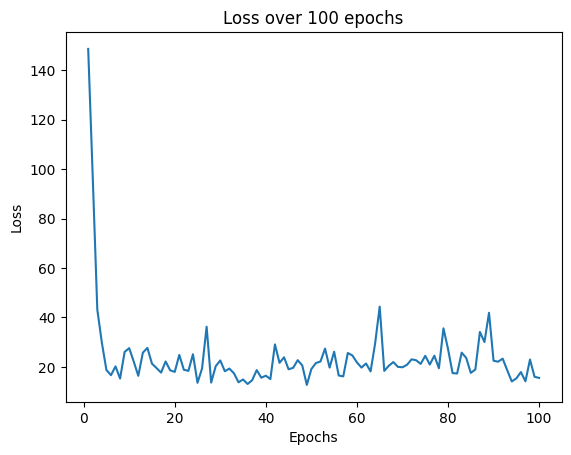

In [54]:
plt.plot(range(1,epochs+1), history.history["loss"])
plt.title(f"Loss over {epochs} epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss");
